In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve
from sklearn import svm

import matplotlib.pyplot as plt
import matplotlib.cm as colormap
%matplotlib inline

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
filename = 'malimg-resnet50features-avgpool.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Loading ResNet50 extracted features from malimg-resnet50features-avgpool.npy ...


In [8]:
resnet50features.shape

(9339, 2048)

In [9]:
# Training top_model
C_range = np.logspace(-10, 10, 21)
param_grid = dict(C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

top_model = GridSearchCV(svm.LinearSVC(), param_grid=param_grid, cv=cv, verbose=10, n_jobs=-1)
top_model.fit(resnet50features,y)  # Training 

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] C=1e-10 .........................................................
[CV] C=1e-10 .........................................................
[CV] C=1e-10 .........................................................
[CV] C=1e-10 .........................................................
[CV] C=1e-10 .........................................................
[CV] C=1e-09 .........................................................
[CV] C=1e-09 .........................................................
[CV] C=1e-09 .........................................................
[CV] C=1e-09 .........................................................
[CV] C=1e-09 .........................................................
[CV] C=1e-08 .........................................................
[CV] C=1e-08 .........................................................
[CV] C=1e-08 .........................................................
[CV] C=1e-08 ..

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.1s


[CV] .......................... C=1e-10, score=0.315846, total=   6.5s
[CV] C=1e-05 .........................................................
[CV] .......................... C=1e-10, score=0.315846, total=   6.5s
[CV] C=1e-05 .........................................................
[CV] .......................... C=1e-10, score=0.315846, total=   8.3s
[CV] C=1e-05 .........................................................
[CV] .......................... C=1e-09, score=0.315846, total=   8.5s
[CV] C=1e-05 .........................................................
[CV] .......................... C=1e-09, score=0.315846, total=   8.9s
[CV] C=0.0001 ........................................................
[CV] .......................... C=1e-09, score=0.315846, total=   9.3s
[CV] C=0.0001 ........................................................
[CV] .......................... C=1e-09, score=0.315846, total=   9.8s
[CV] C=0.0001 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   19.3s


[CV] .......................... C=1e-08, score=0.315846, total=  16.0s
[CV] C=0.001 .........................................................
[CV] .......................... C=1e-08, score=0.315846, total=  16.6s
[CV] C=0.001 .........................................................
[CV] .......................... C=1e-07, score=0.316381, total=  18.9s
[CV] C=0.001 .........................................................
[CV] .......................... C=1e-07, score=0.316381, total=  18.7s
[CV] C=0.01 ..........................................................
[CV] .......................... C=1e-06, score=0.700749, total=  18.5s
[CV] C=0.01 ..........................................................
[CV] .......................... C=1e-07, score=0.315846, total=  19.5s
[CV] C=0.01 ..........................................................
[CV] .......................... C=1e-05, score=0.850107, total=  15.4s
[CV] .......................... C=1e-05, score=0.850107, total=  16.3s
[CV] C

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   25.0s


[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] .......................... C=1e-05, score=0.842612, total=  15.6s
[CV] .......................... C=1e-07, score=0.316916, total=  20.7s
[CV] C=0.1 ...........................................................
[CV] C=1.0 ...........................................................
[CV] .......................... C=1e-06, score=0.701285, total=  21.4s
[CV] C=1.0 ...........................................................
[CV] ......................... C=0.0001, score=0.950749, total=  14.1s
[CV] .......................... C=1e-06, score=0.699143, total=  21.0s
[CV] C=1.0 ...........................................................
[CV] C=1.0 ...........................................................
[CV] .......................... C=1e-06, score=0.703961, total=  21.5s
[CV] C=1.0 ...........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   46.6s


[CV] .......................... C=0.001, score=0.965203, total=  28.2s
[CV] C=100.0 .........................................................
[CV] .......................... C=0.001, score=0.968951, total=  29.1s
[CV] C=100.0 .........................................................
[CV] .......................... C=0.001, score=0.969486, total=  29.0s
[CV] C=100.0 .........................................................
[CV] ........................... C=0.01, score=0.988758, total= 1.1min
[CV] C=100.0 .........................................................
[CV] ........................... C=0.01, score=0.985546, total= 1.2min
[CV] C=1000.0 ........................................................
[CV] ........................... C=0.01, score=0.985011, total= 1.2min
[CV] C=1000.0 ........................................................
[CV] ........................... C=0.01, score=0.985546, total= 1.2min
[CV] C=1000.0 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  1.7min


[CV] ............................ C=1.0, score=0.984475, total= 1.4min
[CV] C=10000.0 .......................................................
[CV] ............................ C=1.0, score=0.981799, total= 1.4min
[CV] C=100000.0 ......................................................
[CV] ............................ C=0.1, score=0.984475, total= 1.4min
[CV] C=100000.0 ......................................................
[CV] ............................ C=0.1, score=0.986081, total= 1.4min
[CV] C=100000.0 ......................................................
[CV] ............................ C=1.0, score=0.985546, total= 1.4min
[CV] ............................ C=1.0, score=0.983405, total= 1.4min
[CV] C=100000.0 ......................................................
[CV] C=100000.0 ......................................................
[CV] ........................... C=10.0, score=0.983405, total= 1.4min
[CV] C=1000000.0 .....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  69 out of 105 | elapsed:  2.8min remaining:  1.4min


[CV] ......................... C=1000.0, score=0.982334, total= 1.2min
[CV] C=100000000.0 ...................................................
[CV] ........................ C=10000.0, score=0.985546, total= 1.1min
[CV] C=100000000.0 ...................................................
[CV] ........................ C=10000.0, score=0.984475, total= 1.2min
[CV] C=1000000000.0 ..................................................
[CV] ........................ C=10000.0, score=0.984475, total= 1.2min
[CV] C=1000000000.0 ..................................................
[CV] ........................ C=10000.0, score=0.987152, total= 1.2min
[CV] C=1000000000.0 ..................................................
[CV] ...................... C=1000000.0, score=0.981799, total= 1.1min
[CV] C=1000000000.0 ..................................................
[CV] ...................... C=1000000.0, score=0.984475, total= 1.2min
[CV] C=1000000000.0 ..................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 out of 105 | elapsed:  3.2min remaining:  1.0min


[CV] ....................... C=100000.0, score=0.983405, total= 1.4min
[CV] ...................... C=1000000.0, score=0.986081, total= 1.3min
[CV] C=10000000000.0 .................................................
[CV] ....................... C=100000.0, score=0.981799, total= 1.4min
[CV] ...................... C=1000000.0, score=0.987152, total= 1.4min
[CV] ...................... C=1000000.0, score=0.983940, total= 1.4min
[CV] ..................... C=10000000.0, score=0.984475, total= 1.3min
[CV] ..................... C=10000000.0, score=0.987152, total= 1.3min
[CV] ..................... C=10000000.0, score=0.983405, total= 1.3min
[CV] ..................... C=10000000.0, score=0.986617, total= 1.1min
[CV] .................... C=100000000.0, score=0.985011, total= 1.1min
[CV] ..................... C=10000000.0, score=0.982334, total= 1.1min


[Parallel(n_jobs=-1)]: Done  91 out of 105 | elapsed:  3.8min remaining:   35.4s


[CV] .................... C=100000000.0, score=0.987152, total= 1.1min
[CV] ................... C=1000000000.0, score=0.983405, total=  58.7s
[CV] .................... C=100000000.0, score=0.983940, total= 1.1min
[CV] .................... C=100000000.0, score=0.981799, total=  59.6s
[CV] .................... C=100000000.0, score=0.986081, total= 1.1min
[CV] ................... C=1000000000.0, score=0.983405, total= 1.0min
[CV] ................... C=1000000000.0, score=0.987152, total= 1.0min
[CV] ................... C=1000000000.0, score=0.981799, total=  50.2s
[CV] .................. C=10000000000.0, score=0.983405, total=  44.8s
[CV] ................... C=1000000000.0, score=0.986617, total=  55.6s
[CV] .................. C=10000000000.0, score=0.983940, total=  47.2s
[CV] .................. C=10000000000.0, score=0.986617, total=  46.3s


[Parallel(n_jobs=-1)]: Done 102 out of 105 | elapsed:  4.0min remaining:    7.1s


[CV] .................. C=10000000000.0, score=0.987687, total=  47.3s
[CV] .................. C=10000000000.0, score=0.981799, total=  47.1s


[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  4.1min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=1, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [10]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 0.01} - score: 0.9868


In [11]:
top_model.cv_results_

{'mean_fit_time': array([  6.58355451,   9.19496984,  15.69217377,  19.62739182,
         20.78473163,  15.51346498,  14.80147533,  26.899301  ,
         70.94461508,  80.53176055,  82.32887926,  79.61823111,
         76.11295199,  69.75678263,  72.15486465,  81.41669765,
         76.84389305,  72.10041051,  63.24238782,  57.76166439,  46.50515895]),
 'mean_score_time': array([ 0.06738758,  0.06451721,  0.07330494,  0.0683434 ,  0.08319197,
         0.08293576,  0.05762887,  0.06373577,  0.05792456,  0.06214542,
         0.06736698,  0.05933652,  0.0605628 ,  0.05742416,  0.06153035,
         0.05904484,  0.05583301,  0.04534731,  0.03694782,  0.03478661,
         0.03111377]),
 'mean_test_score': array([ 0.31584582,  0.31584582,  0.31584582,  0.31638116,  0.70107066,
         0.84668094,  0.94764454,  0.96745182,  0.98683084,  0.9856531 ,
         0.98447537,  0.98468951,  0.98501071,  0.98468951,  0.98468951,
         0.98447537,  0.98468951,  0.98479657,  0.98479657,  0.98447537,
  

In [12]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.31585, std: 0.00000, params: {'C': 1e-10},
 mean: 0.31585, std: 0.00000, params: {'C': 1.0000000000000001e-09},
 mean: 0.31585, std: 0.00000, params: {'C': 1e-08},
 mean: 0.31638, std: 0.00034, params: {'C': 9.9999999999999995e-08},
 mean: 0.70107, std: 0.00161, params: {'C': 9.9999999999999995e-07},
 mean: 0.84668, std: 0.00425, params: {'C': 1.0000000000000001e-05},
 mean: 0.94764, std: 0.00238, params: {'C': 0.0001},
 mean: 0.96745, std: 0.00187, params: {'C': 0.001},
 mean: 0.98683, std: 0.00181, params: {'C': 0.01},
 mean: 0.98565, std: 0.00167, params: {'C': 0.10000000000000001},
 mean: 0.98448, std: 0.00182, params: {'C': 1.0},
 mean: 0.98469, std: 0.00184, params: {'C': 10.0},
 mean: 0.98501, std: 0.00227, params: {'C': 100.0},
 mean: 0.98469, std: 0.00205, params: {'C': 1000.0},
 mean: 0.98469, std: 0.00175, params: {'C': 10000.0},
 mean: 0.98448, std: 0.00192, params: {'C': 100000.0},
 mean: 0.98469, std: 0.00184, params: {'C': 1000000.0},
 mean: 0.98480, std: 0.0018

In [13]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
svm_model = svm.LinearSVC(C=0.01)
train_sizes = np.linspace(.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(svm_model, resnet50features, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)

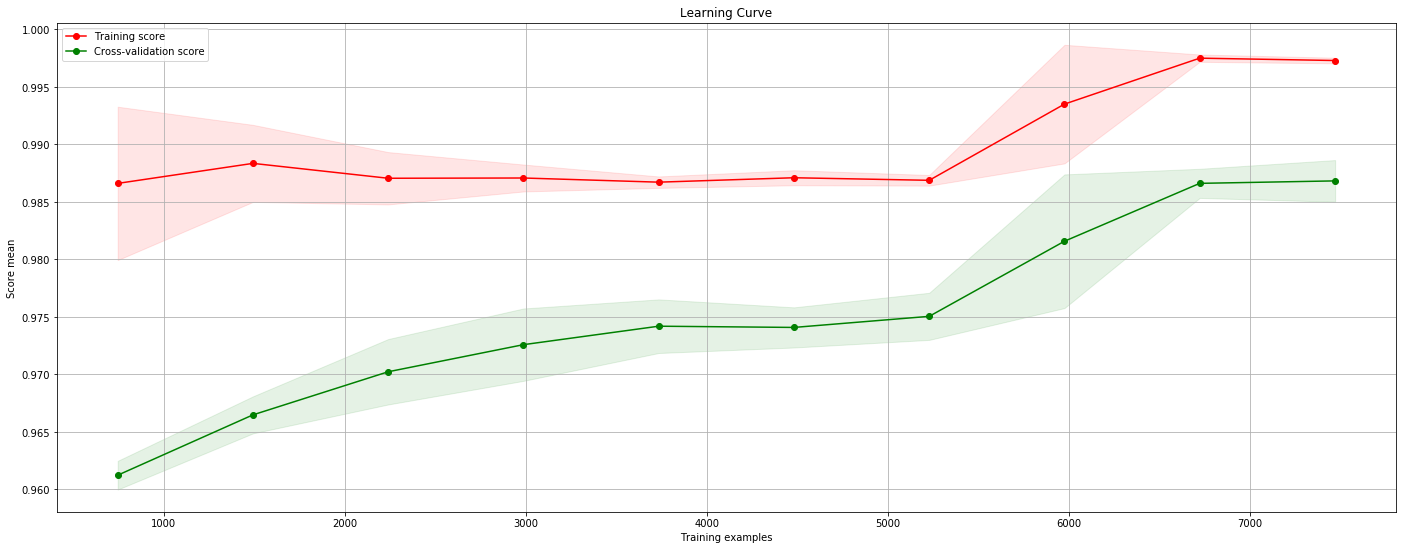

In [14]:
figure = plt.gcf()
figure.set_size_inches(24, 9)
skplot.learning_curve(train_scores, test_scores, train_sizes)
plt.show()